In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import session_config
session_config.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [4]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [5]:
def py_image_process(image, motion_vectors, output_size):
    #image = tf.keras.applications.vgg16.preprocess_input(image)
    image = image / 255.
    image = image.numpy()
    #image = preprocess_input(image)
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    x_s, y_s = tps(control_points[tf.newaxis,::], -motion_vectors[tf.newaxis,::], output_size)
    synth_image = cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC)
    return image, synth_image, motion_vectors

In [6]:
def tf_image_process(image, tps_random_rate, output_size):
    motion_vectors = (tf.random.uniform([9, 2]) - 0.5) * 2 * tps_random_rate
    return tf.py_function(py_image_process, [image, motion_vectors, output_size], [tf.float32, tf.float32, tf.float32])

In [7]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)

ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(16)

In [8]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


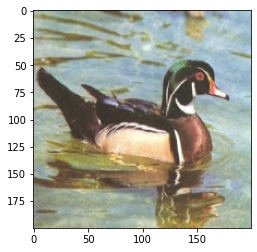

In [42]:
plt.imshow(images[1]/255)

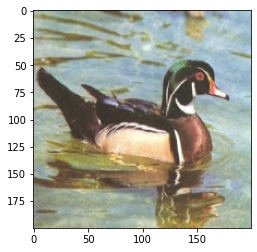

In [43]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


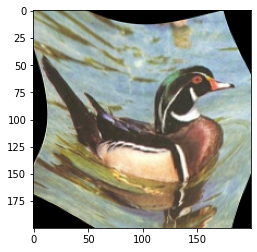

In [44]:
plt.imshow(B[1])

# 2. Model definition

In [12]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [13]:
# (b) channel-wise l2 normalization
def feature_l2_normalization(feature_map):
    #input(feature map) has tensor-shape (N, H, W, D)
    l2_norm = tf.math.sqrt(tf.reduce_sum(tf.pow(feature_map, 2), axis=-1))  # (N, H, W)
    l2_norm = tf.expand_dims(l2_norm, axis=-1)  # (N, H, W, 1)
    # (N, H, W, D) tensor divided by (N, H, W, 1) tensor
    return feature_map / (l2_norm+1E-5)

In [14]:
# (c) Matching layer
class Correlation_network(tf.keras.layers.Layer):
    def __init__(self):
        super(Correlation_network, self).__init__()

    def call(self, feature_A, feature_B):
        # featureA : feature information from source image
        # featureB : feature information from target image
        #assert feature_A.shape == feature_B.shape
        # new feature A and feature B have new shape of tensors.
        # featureA has tensor shape as [batch, HA, WA, 1, 1, depth]
        # featureB has tensor shape as [batch, 1, 1, HB, WB, depth]
        feature_A = feature_A[:, :, :, tf.newaxis, tf.newaxis, :]
        feature_B = feature_B[:, tf.newaxis, tf.newaxis, :, :, :]
        # correlation score has tensor shape as [batch, HA, WA, HB, WB]
        corr_score = tf.reduce_sum(tf.multiply(feature_A, feature_B), axis=-1)
        return corr_score
# repeat penalty
def normalize_correlation(corr_score):
    ambiguous_match_penalty = tf.math.sqrt(tf.reduce_sum(tf.pow(corr_score, 2), axis=[3, 4], keepdims=True))
    corr_score = tf.math.divide(corr_score, ambiguous_match_penalty+0.00001)
    # see eq (2) in "End-to-end weakly-supervised semantic alignment"
    return corr_score

In [15]:
feature_A = feature_extractor(A)
feature_B = feature_extractor(B)
print(feature_A.shape, feature_B.shape)

(10, 25, 25, 512) (10, 25, 25, 512)


In [16]:
normalized_feature_A = feature_l2_normalization(feature_A)
normalized_feature_B = feature_l2_normalization(feature_B)
print(normalized_feature_A.shape, normalized_feature_B.shape)

(10, 25, 25, 512) (10, 25, 25, 512)


In [17]:
correlation_net = Correlation_network()
correlations = correlation_net(normalized_feature_A, normalized_feature_B)
print(correlations.shape)

(10, 25, 25, 25, 25)


In [18]:
correlations = tf.keras.layers.Activation("relu")(correlations)
correlations = normalize_correlation(correlations)

In [19]:
# (d) regressor
class Spatial_regressor(tf.keras.layers.Layer):
    def __init__(self, num_param):
        super(Spatial_regressor, self).__init__()
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, (7, 7)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (5, 5)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_param),
        ])
    def call(self, x):
        AH,AW,BHW = x.shape[1], x.shape[2], x.shape[3]*x.shape[4]
        x = tf.reshape(x, [-1, AH, AW, BHW])
        x = self.regressor(x)
        x = tf.reshape(x, [-1, 9, 2])
        return x

In [20]:
spatial_regressor = Spatial_regressor(9*2)
geo_parameters = spatial_regressor(correlations)
print(geo_parameters.shape)

(10, 9, 2)


In [21]:
class CNN_geotransform(tf.keras.Model):
    def __init__(self, feature_extractor, num_param):
        super(CNN_geotransform, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = Spatial_regressor(9*2)
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)
        return geo_parameters

In [22]:
cnngeo = CNN_geotransform(feature_extractor, 9*2)

In [23]:
geo_paramters = cnngeo(A, B)

In [24]:
cnngeo.summary()

Model: "cnn_geotransform"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25, 25, 512)       7635264   
_________________________________________________________________
correlation_network_1 (Corre multiple                  0         
_________________________________________________________________
spatial_regressor_1 (Spatial multiple                  4384978   
Total params: 12,020,242
Trainable params: 12,019,858
Non-trainable params: 384
_________________________________________________________________


In [25]:
geo_paramters.shape

TensorShape([10, 9, 2])

# 3.Training

In [26]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
cnngeo = CNN_geotransform(feature_extractor, 9*2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

In [27]:
def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean

@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [37]:
train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(200):
    for step, (image_a, image_b, labels) in enumerate(ds):
        print(image_a.shape)
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

(10, 200, 200, 3)
Epoch 1, Loss: 1.0736165046691895
(10, 200, 200, 3)
Epoch 2, Loss: 1.4706226587295532
(10, 200, 200, 3)
Epoch 3, Loss: 1.322141170501709
(10, 200, 200, 3)
Epoch 4, Loss: 1.3339312076568604
(10, 200, 200, 3)
Epoch 5, Loss: 1.1391417980194092
(10, 200, 200, 3)
Epoch 6, Loss: 1.1883538961410522
(10, 200, 200, 3)
Epoch 7, Loss: 1.227884292602539
(10, 200, 200, 3)
Epoch 8, Loss: 1.3176223039627075
(10, 200, 200, 3)
Epoch 9, Loss: 1.2735400199890137
(10, 200, 200, 3)
Epoch 10, Loss: 1.2419090270996094
(10, 200, 200, 3)
Epoch 11, Loss: 1.2670531272888184
(10, 200, 200, 3)
Epoch 12, Loss: 1.3019360303878784
(10, 200, 200, 3)
Epoch 13, Loss: 1.1616672277450562
(10, 200, 200, 3)
Epoch 14, Loss: 1.323514461517334
(10, 200, 200, 3)
Epoch 15, Loss: 1.2231724262237549
(10, 200, 200, 3)
Epoch 16, Loss: 1.2212579250335693
(10, 200, 200, 3)
Epoch 17, Loss: 1.1647944450378418
(10, 200, 200, 3)
Epoch 18, Loss: 1.29617440700531
(10, 200, 200, 3)
Epoch 19, Loss: 1.1669002771377563
(10, 20

(10, 200, 200, 3)
Epoch 156, Loss: 1.0859119892120361
(10, 200, 200, 3)
Epoch 157, Loss: 0.9814361333847046
(10, 200, 200, 3)
Epoch 158, Loss: 1.041191577911377
(10, 200, 200, 3)
Epoch 159, Loss: 1.098550796508789
(10, 200, 200, 3)
Epoch 160, Loss: 1.0465508699417114
(10, 200, 200, 3)
Epoch 161, Loss: 0.9887465834617615
(10, 200, 200, 3)
Epoch 162, Loss: 0.9411563873291016
(10, 200, 200, 3)
Epoch 163, Loss: 0.979595422744751
(10, 200, 200, 3)
Epoch 164, Loss: 0.9829083681106567
(10, 200, 200, 3)
Epoch 165, Loss: 0.9751636385917664
(10, 200, 200, 3)
Epoch 166, Loss: 1.101565957069397
(10, 200, 200, 3)
Epoch 167, Loss: 1.0941143035888672
(10, 200, 200, 3)
Epoch 168, Loss: 0.93853360414505
(10, 200, 200, 3)
Epoch 169, Loss: 0.9731225371360779
(10, 200, 200, 3)
Epoch 170, Loss: 0.936022162437439
(10, 200, 200, 3)
Epoch 171, Loss: 1.0858322381973267
(10, 200, 200, 3)
Epoch 172, Loss: 0.9734807014465332
(10, 200, 200, 3)
Epoch 173, Loss: 0.9047890901565552
(10, 200, 200, 3)
Epoch 174, Loss: 

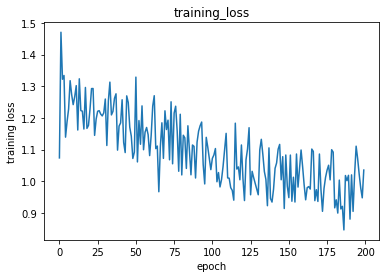

In [38]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [39]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

(10, 200, 200, 3) (10, 200, 200, 3)


In [31]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


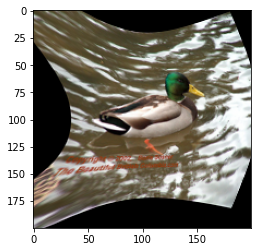

In [40]:
plt.imshow(B[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


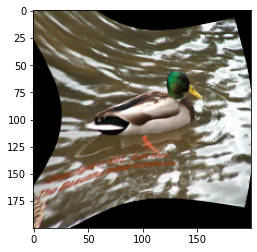

In [41]:
plt.imshow(warping_images[2])

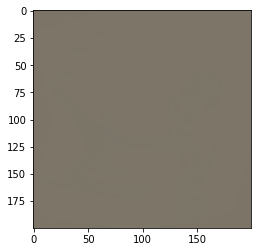

In [34]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

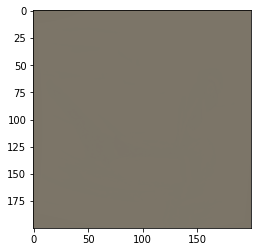

In [35]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)

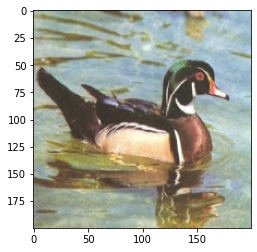

In [36]:
plt.imshow(images[1]/255)